# Simple HandWriting OCR

This simple handwriting will involve custom CNN model by using Tensorflow.
<br>I will call it MinimNet and it can be found in model.py

## 1. Import All and Prepare the Dataset
Before going on, we could download the dataset from the [link Sueiras](https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz) have given.<br>
And just unzip the file in the same directory of this notebook.

In [28]:
from model import MinimNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import resize, grab_contours
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
import numpy as np
import cv2
import os

import all needed libraries and functions needed

And before we are going to prepare the dataset, we would want to set our parameters first

1. Dataset path,
2. Image size,
3. Batch size,
4. Number of epochs,
5. Initial Learning Rate (LR)
6. Ratio of train/test

In [29]:
notebook_path = os.path.abspath('Simple-OCR.ipynb')
dataset_path = os.path.dirname(notebook_path)+'/data'
image_size = (32, 32)
batch_size = 128
epoch = 15
init_lr = 1e-1
test_ratio = .25

After putting all the needed parameters, we then will try to load the images from the path we defined

We will need both the image and label, which the label is the folder name (ASCII Decimal)

Thus we need somekind of label to make it more uniformed.<br> Then we will make a classLabels that consist of needed images to train.

After that we will load all of the images that we need along with the labels<br>
And change the labels into a one-hot label.

In [30]:
classLabels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
classLabels = [i for i in classLabels]

img = []
lbl = []

#initiate for loop to go to all directories
for folder in os.listdir(dataset_path):
    #check whether it is a directory or a file
    if os.path.isdir(dataset_path+'/'+folder):
        # if the folder consist of images we needed then we proceed, else we skip it
        if folder in classLabels:
            lbl_idx = classLabels.index(folder)
            for file in os.listdir(dataset_path+'/'+folder):
                img.append(np.expand_dims(np.array(Image.open(dataset_path+'/'+folder+'/'+file).resize(image_size))*1./255.,axis=-1))
                lbl.append(lbl_idx)

#after loaded all needed images, convert the images to np.array to avoid error
img = np.array(img)
lbl = np.array(lbl)

KeyboardInterrupt: 

In [ ]:
#create a one-hot label
le = LabelBinarizer()
lbl = le.fit_transform(lbl)

#count the total number of images per class
classTotals = lbl.sum(axis=0)
classWeight = {}

#create a custom weight for every class
for i in range(len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
    
#split the class to train and test using scikit train_test_split
(trainImg, testImg, trainLbl, testLbl) = train_test_split(img, lbl,
                                                         test_size = test_ratio,
                                                         stratify = lbl,
                                                         random_state = 42)

After we done in splitting the dataset, we will proceed to the next step.
<br><br>

## 2. Create the Model to train

As I have said before, we will try to build a model.<br>
This model will be consisting of some layers such as:
1. Bottleneck Layer,
2. Inverted Bottleneck Layer,
3. Squeeze Global Layer,
4. SE Module.

The model could be checked in the Model.py or in the summary below.

In [ ]:
model = MinimNet((image_size[0], image_size[1], 1), len(classTotals))
model.summary()

opt = SGD(lr=init_lr, decay=init_lr/epoch)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 32, 32, 4)    104         ['input_3[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 8)    296         ['conv2d_32[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 8)   0           ['conv2d_33[0][0]']              
                                                                                            

C:\Users\enzoc\.conda\envs\PROJETS4\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Now after we have the model, it is time to start training the model.

## 3. Train the model

Now, we will make an augmentation for the training batch so that it could have more variations of the dataset.<br>
We will also make an additional module from tensorflow such as:

1. EarlyStopping : To stop the training if there's no improvement on the monitored variable,
2. ModelCheckpoint : To save the model/weight if it reached higher value on the monitored variable,
3. ReduceLROnPlateau : To reduce the LR if there's no improvement on the monitored variable.

In [ ]:
aug = ImageDataGenerator(rotation_range=10, zoom_range=.05,
                        width_shift_range=.1, height_shift_range=.1,
                        shear_range=.15, horizontal_flip=False,
                        fill_mode='nearest')

eS = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mChk = ModelCheckpoint('OCR Model.h5', save_best_only=True, monitor='val_loss', mode='min')
rLR = ReduceLROnPlateau(monitor='val_loss', factor=.01, patience=10, verbose=1, min_lr=1e-6, mode='min')

In [ ]:
h = model.fit(aug.flow(trainImg, trainLbl, batch_size=batch_size),
             validation_data=(testImg, testLbl),
             steps_per_epoch=len(trainImg)//batch_size,
             epochs=epoch, callbacks=[eS, mChk, rLR],
             class_weight=classWeight, verbose=2)

Epoch 1/15
2182/2182 - 141s - loss: 1.1568 - accuracy: 0.9149 - val_loss: 0.1232 - val_accuracy: 0.9638 - lr: 0.1000 - 141s/epoch - 64ms/step
Epoch 2/15
2182/2182 - 140s - loss: 0.5189 - accuracy: 0.9601 - val_loss: 0.1065 - val_accuracy: 0.9688 - lr: 0.1000 - 140s/epoch - 64ms/step
Epoch 3/15
2182/2182 - 140s - loss: 0.4619 - accuracy: 0.9639 - val_loss: 0.0948 - val_accuracy: 0.9727 - lr: 0.1000 - 140s/epoch - 64ms/step
Epoch 4/15
2182/2182 - 138s - loss: 0.4330 - accuracy: 0.9662 - val_loss: 0.0943 - val_accuracy: 0.9727 - lr: 0.1000 - 138s/epoch - 63ms/step
Epoch 5/15
2182/2182 - 140s - loss: 0.4138 - accuracy: 0.9677 - val_loss: 0.0863 - val_accuracy: 0.9751 - lr: 0.1000 - 140s/epoch - 64ms/step
Epoch 6/15
2182/2182 - 139s - loss: 0.3952 - accuracy: 0.9690 - val_loss: 0.0846 - val_accuracy: 0.9756 - lr: 0.1000 - 139s/epoch - 64ms/step
Epoch 7/15
2182/2182 - 139s - loss: 0.3908 - accuracy: 0.9694 - val_loss: 0.0857 - val_accuracy: 0.9753 - lr: 0.1000 - 139s/epoch - 64ms/step
Epoch 

After training, we will plot the result of the training, such as the loss and accuracy.

Here, we will use the pyplot to plot the result into an image called Result.png

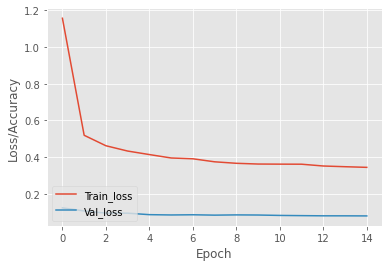

In [ ]:
n = np.array(range(len(h.history['loss'])))
plt.style.use('ggplot')
plt.figure()
plt.plot(n, h.history['loss'], label='Train_loss')
plt.plot(n, h.history['val_loss'], label='Val_loss')
plt.title=('Training Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('Result.png')

Then we will test it, and show each class result in F1 score using sklearn classification_report

In [ ]:
predictions = model.predict(testImg, batch_size=batch_size)
print(classification_report(testLbl.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=classLabels))

              precision    recall  f1-score   support

           A       0.98      0.98      0.98      3468
           B       0.95      0.98      0.96      2167
           C       0.99      0.98      0.98      5852
           D       0.85      0.97      0.91      2533
           E       0.98      0.97      0.98      2860
           F       0.92      0.99      0.95       291
           G       0.93      0.98      0.95      1440
           H       0.91      0.96      0.94      1804
           I       0.91      0.99      0.95       280
           J       0.94      0.98      0.96      2123
           K       0.95      0.98      0.97      1401
           L       0.98      0.99      0.99      2897
           M       0.98      0.98      0.98      3084
           N       0.98      0.97      0.98      4753
           O       0.99      0.96      0.98     14456
           P       0.99      0.98      0.99      4835
           Q       0.92      0.98      0.95      1453
           R       0.99    

And its finished! But only for the model part.

Next, we will combine this with OpenCV to make it into real OCR and read multiple character in the images at once.

## 4. Combining with OpenCV
In this step we will:
1. Load an image containing handwriting using OpenCV,
2. Convert the image into Grayscale,
3. Apply some image processing,
4. Get the contours and sort them from left to right,
5. Crop images based on the contours,
6. Predict each image from the cropped image,
7. Append the result to the image.

In [ ]:
# put all the needed variable/parameter
file_name = 'image_to_test.jpg'
image_path = os.path.dirname(notebook_path)+'/'+file_name

image_to_test = cv2.imread(image_path)

#convert to grayscale
gray = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)
#blurring the image
blur = cv2.GaussianBlur(gray, (5, 5), 0)

#apply edge filter to the blurred image
edge = cv2.Canny(blur, 30, 150)

In [ ]:
#get contours
cntrs = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cntrs = grab_contours(cntrs)

#sort contours from top left to bottom right
boundingBox = [cv2.boundingRect(c) for c in cntrs]
(cntrs, _) = zip(*sorted(zip(cntrs, boundingBox), key=lambda x: (-x[1][1], x[1][0])))

In [ ]:
char_detected = []

for c in cntrs:
    (x,y,w,h) = cv2.boundingRect(c)
    
    #attemp to ignore small contours
    if (w >= 5 and w <= 350) and (h >= 15 and h <= 320):
        #create an Region of Interest
        roi = gray[y:y+h, x:x+w]
        
        #threshold it to make it into binary image
        bin_img = cv2.threshold(roi, 0 ,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (iH, iW) = bin_img.shape
        
        #if imageWidth(iW) is bigger than the Height, then we will scale the image until
        #the width is equal to 32, else scale the image until we got the height is the 32
        #32 used in here is based on the image_size which is (32,32)
        if iW > iH:
            bin_img = resize(bin_img, width = image_size[0])
        else:
            bin_img = resize(bin_img, height = image_size[1])
            
        #update with the new image size
        (iH, iW) = bin_img.shape
        dX = int(max(0, 32 - iW) / 2.0)
        dY = int(max(0, 32 - iH) / 2.0)
        
        #pad the image and resize it to match the input of the model
        padded = cv2.copyMakeBorder(bin_img, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0))
        padded = cv2.resize(padded, image_size)
        
        #normalize the image so that it got the same value of testImg
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        
        #put it into list of the queue of images to predict
        char_detected.append([padded, (x, y, w, h)])
        
#get each location and image of detected char
boxes = [b[1] for b in char_detected]
char_detected = np.array([c[0] for c in char_detected], dtype="float32")
#feed it as the input of the model
predictions = model.predict(char_detected)
preds = []
for pred in predictions:
    i = np.argmax(pred)
    prob = pred[i]
    preds.append([classLabels[i], prob])

for (pred, (x, y, w, h)) in zip(preds, boxes):
    #put the result into the image and print it
    print("[DETECTED CHAR] {} - {:.2f}%".format(pred[0], pred[1] * 100))
    cv2.rectangle(image_to_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_to_test, "{}".format(pred[0]), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

#show the result
cv2.imwrite("Image_after_test.jpg", image_to_test)

[DETECTED CHAR] N - 99.39%
[DETECTED CHAR] N - 99.94%
[DETECTED CHAR] D - 91.42%
[DETECTED CHAR] G - 98.81%
[DETECTED CHAR] L - 98.74%
[DETECTED CHAR] R - 99.15%
[DETECTED CHAR] A - 99.02%
[DETECTED CHAR] L - 95.72%
[DETECTED CHAR] T - 99.90%
[DETECTED CHAR] D - 98.32%
[DETECTED CHAR] R - 42.07%
[DETECTED CHAR] O - 99.40%
[DETECTED CHAR] M - 75.61%
[DETECTED CHAR] X - 86.61%
[DETECTED CHAR] E - 87.64%
[DETECTED CHAR] S - 99.53%
[DETECTED CHAR] J - 64.86%
[DETECTED CHAR] N - 99.37%
[DETECTED CHAR] D - 99.52%
[DETECTED CHAR] L - 52.26%
[DETECTED CHAR] H - 99.21%
[DETECTED CHAR] T - 99.95%
[DETECTED CHAR] D - 78.50%
[DETECTED CHAR] D - 96.68%
[DETECTED CHAR] Z - 84.53%
[DETECTED CHAR] I - 95.60%
[DETECTED CHAR] C - 99.70%
[DETECTED CHAR] O - 87.46%
[DETECTED CHAR] R - 100.00%
[DETECTED CHAR] L - 86.84%
[DETECTED CHAR] S - 98.17%
[DETECTED CHAR] L - 99.94%
[DETECTED CHAR] E - 99.36%
[DETECTED CHAR] N - 98.93%
[DETECTED CHAR] M - 98.62%
[DETECTED CHAR] P - 99.99%
[DETECTED CHAR] O - 92.69%


True

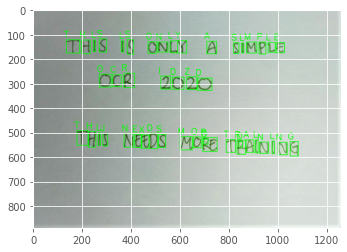

In [ ]:
#show the result
plt.imshow(image_to_test)

As we can see the result shows:
<br>
"This is only a jimple ocr 2020 thij nekds momd troaining"

There are some errors on the S and The insides of R, which always shows up as D or O.<br>
And RE that connected also read as M.

And that's it! Congratulation, you have reached the end of this tutorial!

But as we can see that the result is still not that good.<br>
There are still things that we can do to fix this such as:
1. Make the the minimum size bigger,
2. Maybe train it more or try to use other network,
3. Try to train using other dataset.